# Д.А., Machine Learning.
## Задача: обучение модели для определения спама.

### Условия.
Имеется имеется два датасета: тренировочный и тестовый. В тренировочном имеется два столбца: text_type - столбец, определяющая тип сообщения, text - текст сообщения. В тестовом есть только столбец из текстов сообщения.

### План.
1. Получим данные из файла тренировочного датасета и обработаем, убрав элементы, не имеющие флага, если они есть.
2. Векторизировать данные.
3. Обучить модель.
4. Обработать данные из тестового датасета и сохранить результаты обработки в файл разрешения .csv

## 1. Первый споособ. TF-IDF.

1. Загрузим все необходимые модули и получим данные из файла, после чего посмотрим на размеры датасета (количество строк и столбцов)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("train_spam.csv")

print(train_data.shape)

(16278, 2)


Выведем несколько элементов таблиы.

In [18]:
train_data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


Определим уникальные значения флагов в датасете для дальнейшего удаления неопределенных сообщений

In [19]:
unique_lables = train_data['text_type'].unique()
print(unique_lables)

['ham' 'spam']


In [20]:
train_data = train_data.dropna(subset=['text_type'])
train_data = train_data[train_data['text_type'].isin(unique_lables)]
train_data['text_type'].unique()
train_data.shape

(16278, 2)

В данном случае ничего не изменилось - данные подобраны без пропущенных флагов.

Посмотрим на распределение спама и не спама в датасете.

Распределение классов:
text_type
ham     11469
spam     4809
Name: count, dtype: int64


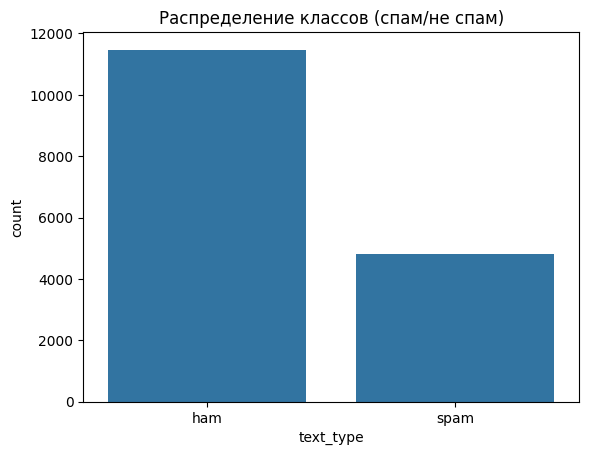

In [21]:
class_counts = train_data['text_type'].value_counts()
print("Распределение классов:")
print(class_counts)

# Визуализация распределения классов
sns.countplot(x='text_type', data=train_data)
plt.title("Распределение классов (спам/не спам)")
plt.show()

2. Начинаем векторизацию.
Перед началом векторизации, то есть приведения текста в числовые векторы, для начала обработаем текст, приведя все буквы к одному виду. Текст будет представлять собой набор строчных латинских (английских) букв, среди них не будет общих слов, таких как or, but, etc.
В данном случае для векторизации будет использован метод TF-IDF, учитывающий частоту слова и его значимость по отношению к другим словам текста.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X = tfidf_vectorizer.fit_transform(train_data['text'])
y = train_data['text_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Обучение модели
model = MultinomialNB()
model.fit(X_train, y_train)

# Оценка модели на тестовых данных
y_pred = model.predict(X_test)

Итоги классификации и полученная точность:

In [24]:
print(classification_report(y_test, y_pred))
print("Точность:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.87      0.98      0.93      2321
        spam       0.94      0.65      0.77       935

    accuracy                           0.89      3256
   macro avg       0.90      0.82      0.85      3256
weighted avg       0.89      0.89      0.88      3256

Точность: 0.8866707616707616


In [25]:
test_data = pd.read_csv("test_spam.csv")

test_vectorized = tfidf_vectorizer.transform(test_data['text'])
test_predictions = model.predict(test_vectorized)

test_data['score'] = test_predictions
result_df = test_data[['score', 'text']]

result_df.to_csv("scored_results_tf.csv", index=False)

Распределение классов:
score
ham     3255
spam     815
Name: count, dtype: int64


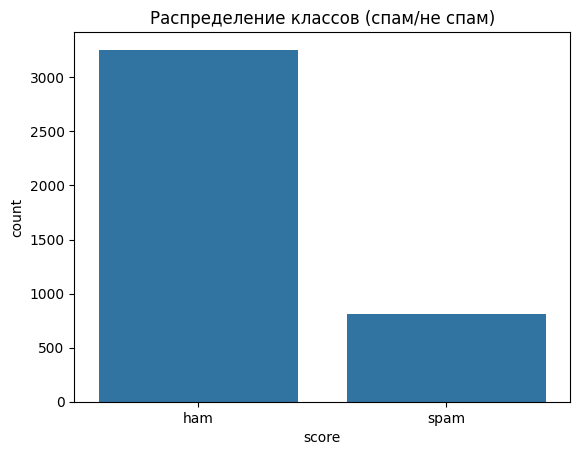

In [26]:
scored_data = pd.read_csv("scored_results_tf.csv")
class_counts = scored_data['score'].value_counts()
print("Распределение классов:")
print(class_counts)

sns.countplot(x='score', data=scored_data)
plt.title("Распределение классов (спам/не спам)")
plt.show()

### Второй способ. Метод текстовых эмбеддингов.

1.

In [49]:
train_df = pd.read_csv('train_spam.csv')
test_df = pd.read_csv('test_spam.csv')

train_df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [48]:
test_df.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [47]:

train_df['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

In [30]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

text_type    0
text         0
dtype: int64
text    0
dtype: int64


In [38]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import gensim

# Удаление стоп-слов и приведение текста к нижнему регистру
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление знаков препинания и чисел
    text = re.sub(r'[^a-z\s]', '', text)
    # Токенизация
    words = word_tokenize(text)
    # Удаление стоп-слов
    words = [word for word in words if word not in stop_words]
    return words

# Применение предобработки
train_df['tokens'] = train_df['text'].apply(preprocess_text)
test_df['tokens'] = test_df['text'].apply(preprocess_text)

train_df.head()
test_df.head()

,text,tokens
0,j jim whitehead ejw cse ucsc edu writes j you ...,"[j, jim, whitehead, ejw, cse, ucsc, edu, write..."
1,original message from bitbitch magnesium net p...,"[original, message, bitbitch, magnesium, net, ..."
2,java for managers vince durasoft who just taug...,"[java, managers, vince, durasoft, taught, java..."
3,there is a youtuber name saiman says,"[youtuber, name, saiman, says]"
4,underpriced issue with high return on equity t...,"[underpriced, issue, high, return, equity, oil..."


In [40]:
w2v_model = gensim.models.Word2Vec(train_df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

def get_message_vector(tokens):
    # Берем среднее по всем словам в сообщении
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        # Если нет подходящих слов, возвращаем вектор нулей
        return [0] * w2v_model.vector_size


In [41]:
train_df['vector'] = train_df['tokens'].apply(get_message_vector)
test_df['vector'] = test_df['tokens'].apply(get_message_vector)

X_train, X_val, y_train, y_val = train_test_split(
    train_df['vector'].tolist(),
    train_df['text_type'],
    test_size=0.2,
    random_state=42
)
j
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.8427518427518428
Classification Report:
               precision    recall  f1-score   support

         ham       0.86      0.93      0.89      2321
        spam       0.78      0.62      0.69       935

    accuracy                           0.84      3256
   macro avg       0.82      0.78      0.79      3256
weighted avg       0.84      0.84      0.84      3256



In [44]:
test_scores = classifier.predict_proba(test_df['vector'].tolist())[:, 1]

result_df = pd.DataFrame({
    'score': test_scores,
    'text': test_df['text']
})

result_df.head()

result_df.to_csv('scored_results_w2v.csv', index=False)

Распределение классов:
score
0.463234    84
0.526987     3
0.000002     3
0.340287     3
0.999997     3
            ..
0.004818     1
0.245809     1
0.075457     1
0.212682     1
0.007252     1
Name: count, Length: 3956, dtype: int64


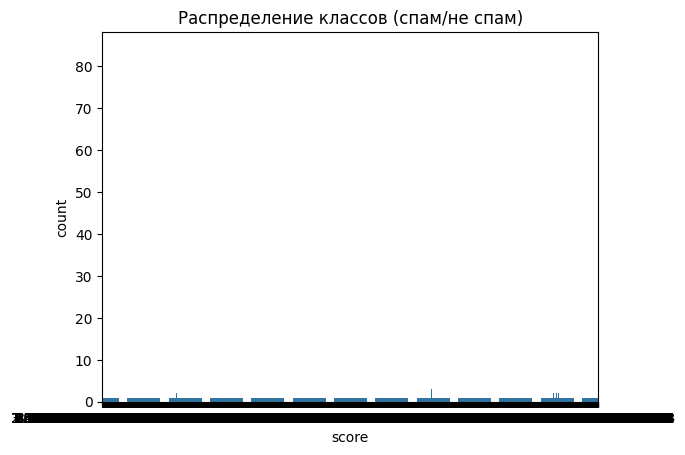

In [45]:
scored_data = pd.read_csv("scored_results_w2v.csv")
class_counts = scored_data['score'].value_counts()
print("Распределение классов:")
print(class_counts)

sns.countplot(x='score', data=scored_data)
plt.title("Распределение классов (спам/не спам)")
plt.show()